In [1]:
from learner import Trainer, EvaluateOnTest
from model import SpanEmo
from data_loader import DataClass
from data_selector import DataSelector
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json

seed = 12345678

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("WARNING: USING CPU")

Currently using GPU: cuda:0


In [3]:
def make_loaders(args, data, batch_size, shuffle=True):
    dataset = DataClass(args, data)
    data_loader = DataLoader(dataset,
                             batch_size=int(batch_size),
                             shuffle=shuffle)

    print('The number of batches: ', len(data_loader))

    return data_loader

In [4]:
def make_model(args):
    model = SpanEmo(output_dropout=args['output_dropout'],
                    backbone=args['backbone'])
    
    return model


In [5]:
def pipeline(args, loaders=None):
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d-%H:%M:%S")
    fw = open('configs/' + filename + '.json', 'a')
    json.dump(args, fw, sort_keys=True, indent=2)

    train_data_loader, val_data_loader = loaders
    model = make_model(args)

    learn = Trainer(model, train_data_loader, val_data_loader, filename=filename)
    learn.fit(
        num_epochs=int(args['max_epoch']),
        args=args,
        device=device
    )

In [6]:
hyperparams = {
    'train_path':'data/train.csv', 
    'val_path':'data/val.csv',
    'backbone':'bert-base-uncased',
    'train_batch_size': 32,
    'val_batch_size': 32,
    'output_dropout': 0.1,
    'max_epoch': 20,
    'max_length': 512,
    'ffn_lr': 0.001,
    'bert_lr': 2e-5
}

In [7]:
assert False

AssertionError: 

## Train

In [8]:
def filter_neutrals(df):
    df["filter"] = df['27'] < 2
    return df

In [9]:
ds = DataSelector("data.csv")
train, val, tests = ds.select_data(ratio={"IEMOCAP": 1, "Cornell": 3}, filter=None)

Filtering...
Calculating counts...
Grabbing data...


In [ ]:
m = 0
c = 0
tc = 0
for i in train_loader.dataset:
    tc += 1
    ma = i[0]['attention_mask'].sum()
    if ma > 1:
        # print(i[0]['input_ids'])
        print(ma)
        if ma > m: m = ma
        c += 1

print(m)
print(c)
print(tc)

tensor(120)
tensor(123)
tensor(110)
tensor(170)
tensor(183)
tensor(122)
tensor(121)
tensor(249)
tensor(299)
tensor(141)
tensor(161)
tensor(147)
tensor(107)
tensor(109)
tensor(232)
tensor(98)
tensor(143)
tensor(106)
tensor(127)
tensor(109)
tensor(139)
tensor(163)
tensor(97)
tensor(237)
tensor(154)
tensor(110)
tensor(149)
tensor(95)
tensor(99)
tensor(132)
tensor(104)
tensor(166)
tensor(97)
tensor(146)
tensor(109)
tensor(132)
tensor(116)
tensor(104)
tensor(126)
tensor(113)
tensor(96)
tensor(177)
tensor(187)
tensor(151)
tensor(133)
tensor(172)
tensor(117)
tensor(132)
tensor(109)
tensor(142)
tensor(177)
tensor(116)
tensor(105)
tensor(110)
tensor(116)
tensor(110)
tensor(193)
tensor(146)
tensor(108)
tensor(143)
tensor(133)
tensor(116)
tensor(99)
tensor(109)
tensor(107)
tensor(186)
tensor(152)
tensor(116)
tensor(121)
tensor(79)
tensor(130)
tensor(126)
tensor(93)
tensor(168)
tensor(191)
tensor(131)
tensor(262)
tensor(173)
tensor(103)
tensor(184)
tensor(168)
tensor(91)
tensor(109)
tensor(134)
te

In [10]:
train_loader = make_loaders(hyperparams, train, hyperparams['train_batch_size'])
val_loader = make_loaders(hyperparams, val, hyperparams['val_batch_size'])
loaders = (train_loader, val_loader)

/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 30825/30825 [01:29<00:00, 345.92it/s]


The number of batches:  964
Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 3853/3853 [00:11<00:00, 338.27it/s]

The number of batches:  121


In [11]:
#wooooooooooooooooooooo
pipeline(hyperparams, loaders=loaders)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future vers

Train_Loss,Val_Loss,RMSE-Macro,RMSE-Micro,MSE-Micro,Time
0.1640,0.1432,0.1338,0.1104,0.0179,10:15
0.1429,0.1432,0.1343,0.1105,0.0180,10:17
0.1403,0.1411,0.1327,0.1094,0.0176,10:20
0.1361,0.1394,0.1306,0.1081,0.0170,10:23
0.1302,0.1439,0.1358,0.1116,0.0184,10:31
0.1229,0.1426,0.1333,0.1101,0.0178,10:29
0.1155,0.1518,0.1401,0.1151,0.0196,10:28
0.1090,0.1538,0.1438,0.1174,0.0207,10:24


epoch#:  1
Validation loss decreased (inf --> 0.143152).  Saving model ...
epoch#:  2
EarlyStopping counter: 1 out of 5
epoch#:  3
Validation loss decreased (0.143152 --> 0.141080).  Saving model ...
epoch#:  4
Validation loss decreased (0.141080 --> 0.139390).  Saving model ...
epoch#:  5
EarlyStopping counter: 1 out of 5
epoch#:  6
EarlyStopping counter: 2 out of 5
epoch#:  7
EarlyStopping counter: 3 out of 5
epoch#:  8
EarlyStopping counter: 4 out of 5


KeyboardInterrupt: 

## Test

In [12]:
def test(args, model_path, loader=None):

    if loader is None:
        test_data_loader = make_loaders(args, test=True)
    else:
        test_data_loader = loader

    model = make_model(args)
    
    learn = EvaluateOnTest(model, test_data_loader, model_path='models/' + model_path)
    return learn.predict(device=device), model

In [13]:
hyperparams['test_batch_size'] = 32

In [14]:
test_loader = make_loaders(hyperparams, tests, hyperparams['test_batch_size'], shuffle=False)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 3854/3854 [00:11<00:00, 342.49it/s]

The number of batches:  121


In [15]:
preds, model = test(hyperparams, "2023-11-26-19:58:26_checkpoint.pt", loader=test_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RMSE-Macro: 0.1314 RMSE-Micro: 0.1073 MSE-Micro: 0.0173 Time: 00:25


In [16]:
y_true = torch.cat([x[1] for x in test_loader])

In [20]:
y_prob = torch.rand(y_true.shape)

In [21]:
from sklearn.metrics import mean_squared_error

stats = [mean_squared_error(y_true.flatten(), y_prob.flatten(), squared=False),
        mean_squared_error(y_true, y_prob, squared=False),
        mean_squared_error(y_true, y_prob, squared=True)]


In [22]:
stats

[0.5592424592428694, 0.5585544394087971, 0.31275212822001225]

In [ ]:
mean_squared_error(y_true, y_prob, squared=False, multioutput="raw_values")

array([0.2255486 , 0.08669251, 0.19153291, 0.14592714, 0.28868008,
       0.15107506, 0.18478411, 0.4136269 , 0.09696561, 0.08235464,
       0.27748666, 0.05194096, 0.02802926, 0.06927852, 0.09722859,
       0.12457933, 0.04215802, 0.07982036, 0.13173151, 0.03791139,
       0.11213723, 0.02602776, 0.07401515, 0.01366026, 0.08590142,
       0.10215934, 0.10040046, 0.58242812])

In [23]:
dc = DataClass(hyperparams, [
    [
        "i just lost my job today. it's devastating", 
        "i just found a job today, i'm so happy", 
        "this is miserable. i feel like a failure.", 
        "i can't believe my good fortune!"
    ], [
        "I just got a promotion at work! I'm so excited and proud of myself!",
        "Wow, that's fantastic news! Congratulations! 🎉",
        "Thanks! It's been a long journey, but I finally feel recognized for my efforts.",
        "I can imagine the hard work you've put in. Your dedication has paid off. How do you feel now?",
    ]], pred_mode=True)
dl = DataLoader(dc, batch_size=100, shuffle=False)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 2/2 [00:00<00:00, 329.08it/s]


In [32]:
rows = tests.iterrows()
x = 0

In [99]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = ["."]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    print(font_file)
    font_manager.fontManager.addfont(font_file)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model2/model/cour.ttf
/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model2/model/times.ttf


In [102]:
sns.set_theme(font="Times New Roman", style="dark")

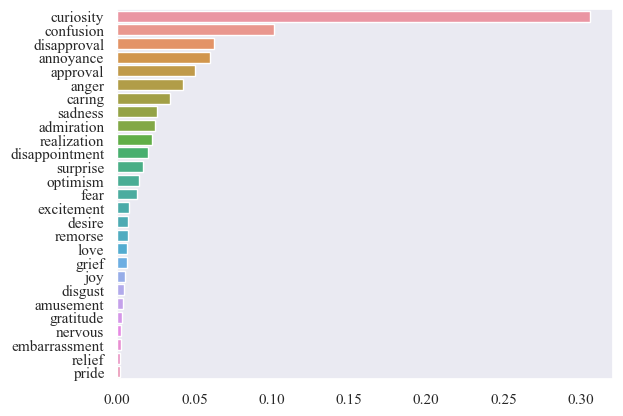

: 

In [114]:
import seaborn as sns

data = sorted(zip(p[:-1], label_names[:-1]), reverse=True)

g = sns.barplot(y=[d[1] for d in data], x=[d[0] for d in data], orient="h")
# g.tick_params(axis="x", rotation=90)

Tell me, Michael. What really happened with Pentangeli?
His brother came to help him.
I didn't even know he had a brother. And where is he now?
On a plane back to Sicily.
0.009 0.024 admiration
0.001 0.004 amusement
0.003 0.042 anger
0.012 0.060 annoyance
0.127 0.050 approval
0.003 0.034 caring
0.000 0.101 confusion
0.000 0.306 curiosity
0.001 0.007 desire
0.001 0.020 disappointment
0.001 0.063 disapproval
0.000 0.004 disgust
0.000 0.002 embarrassment
0.002 0.007 excitement
0.000 0.013 fear
0.001 0.003 gratitude
0.000 0.006 grief
0.001 0.005 joy
0.000 0.006 love
0.000 0.002 nervous
0.005 0.014 optimism
0.000 0.002 pride
0.008 0.023 realization
0.001 0.002 relief
0.000 0.007 remorse
0.000 0.026 sadness
0.001 0.017 surprise
0.972 0.664 neutral


<Axes: >

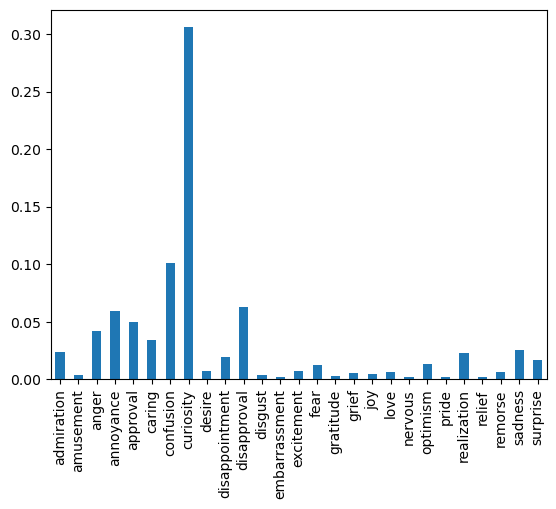

In [51]:
label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

i, row = next(rows)
text = row["text"]
probs = row.loc["0":"27"].values.astype(float)
probs = 1/(1+np.exp(-probs))
p = 1/(1+np.exp(-preds["logits"][x]))
for i in text:
    print(i)
for i in range(28):
    print(f"{probs[i]:.3f} {p[i]:.3f}", label_names[i])
x += 1

pdf = pd.Series(p[:-1], label_names[:-1])
pdf.plot.bar()

In [ ]:
logits = model.predict(next(iter(dl)), device)[2].cpu().detach().numpy()
probs = 1/(1+np.exp(-logits))[1]


In [ ]:
label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

for i in range(28):
    print(f"{probs[i]:.3f}", label_names[i])


0.173 admiration
0.013 amusement
0.013 anger
0.024 annoyance
0.258 approval
0.061 caring
0.048 confusion
0.131 curiosity
0.028 desire
0.039 disappointment
0.138 disapproval
0.004 disgust
0.004 embarrassment
0.063 excitement
0.006 fear
0.146 gratitude
0.004 grief
0.062 joy
0.033 love
0.005 nervous
0.050 optimism
0.015 pride
0.062 realization
0.015 relief
0.036 remorse
0.037 sadness
0.052 surprise
0.385 neutral


In [ ]:
label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

y_true = pd.DataFrame(preds['y_true'], columns=label_names)
y_pred = pd.DataFrame(preds['y_pred'], columns=label_names)
logits = pd.DataFrame(preds['logits'], columns=label_names)

correlation = "pearson"

y_true_corr = y_true.corr(correlation)
y_pred_corr = y_pred.corr(correlation)
logits_corr = logits.corr(correlation)

In [ ]:
# _ = sns.clustermap(logits_corr, annot=False)

In [ ]:
# data = pd.read_csv("data/test.csv")

# wrongs = [(i[0], i[1].sum(), [(j, label_names[j]) for j, x in enumerate(i[1]) if x]) for i in enumerate(preds['y_true'] != preds['y_pred']) if i[1].any()]
# test_data = [(i, data['text'][i], [(j, label_names[j]) for j in range(28) if data[str(j)][i]]) for i in data.index]
# test_data = [test_data[i[0]] for i in wrongs]